# Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import scatterplotmatrix, heatmap

AMES_HOUSING_DATASET_URL = 'http://jse.amstat.org/v19n3/decock/AmesHousing.txt'
AMES_HOUSING_DATASET_COLUMNS = [
    'Overall Qual', 'Overall Cond', 'Gr Liv Area', 'Central Air', 'Total Bsmt SF', 'SalePrice'
]

def load_ames_housing_data() -> pd.DataFrame :
    
    def _format_central_air(series : pd.Series) -> pd.Series :
        
        return series.map(
            {
                'Y' : 1,
                'N' : 0
            }
        )
        
    ames_df = pd.read_csv(
        filepath_or_buffer=AMES_HOUSING_DATASET_URL,
        usecols=AMES_HOUSING_DATASET_COLUMNS,
        sep='\t', 
    )
    
    assert ames_df.shape == (2930, 6) # ensure data isn't malformatted
    
    ames_df['Central Air'] = _format_central_air(ames_df['Central Air'])
    
    ames_df = ames_df.dropna(how='any', axis=0) # remove records with any null values 
    
    assert (ames_df.isnull().sum() == 0).all() # ensure no features have null values
    
    return ames_df

ames_df = load_ames_housing_data()

## Visualizing Feature Importance via Scatterplot Matrix

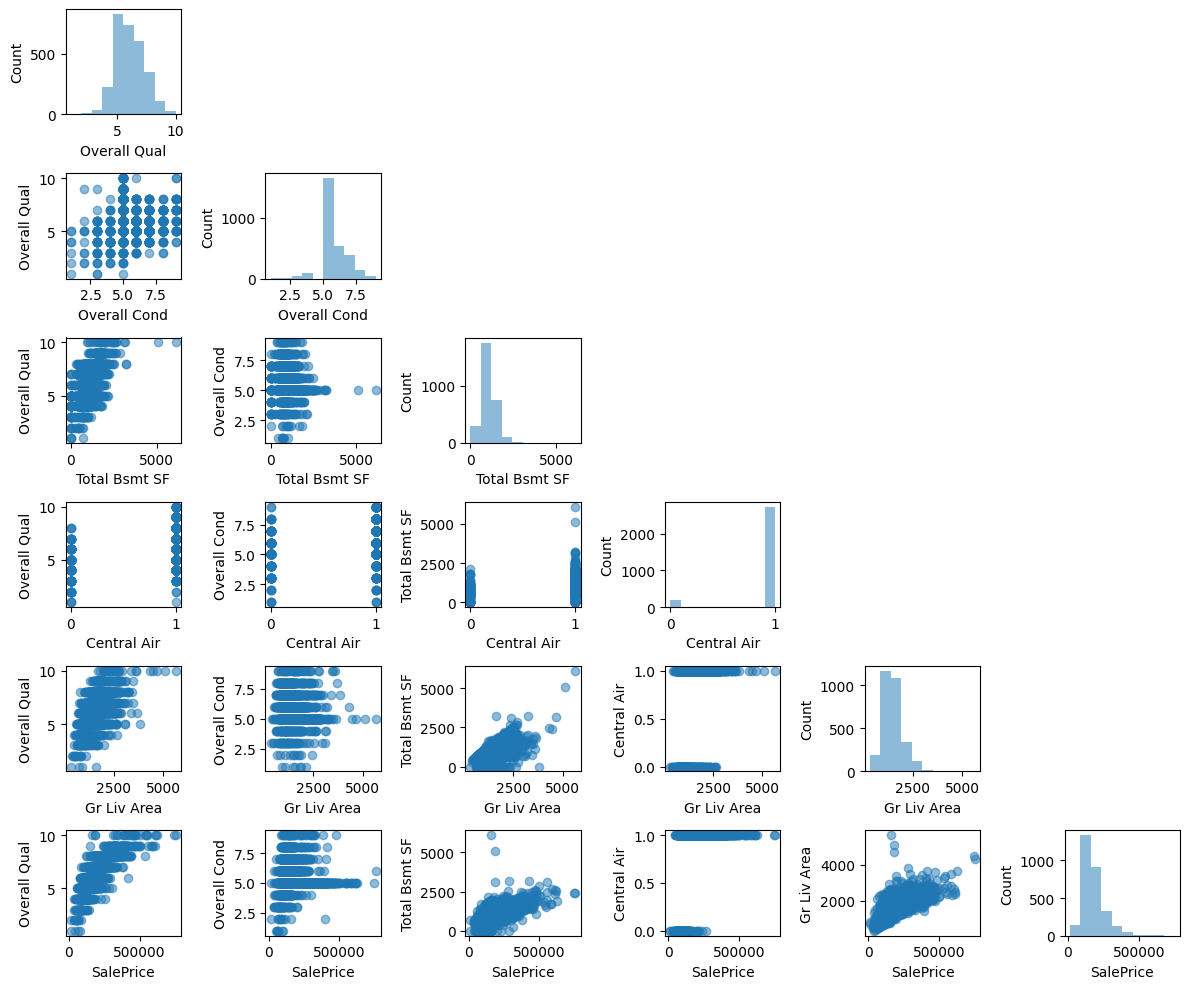

In [3]:
scatterplotmatrix(X=ames_df.values, figsize=(12, 10), names=ames_df.columns, alpha=.5)
plt.tight_layout()

## Analysis of Relationships using a Correlation Matrix

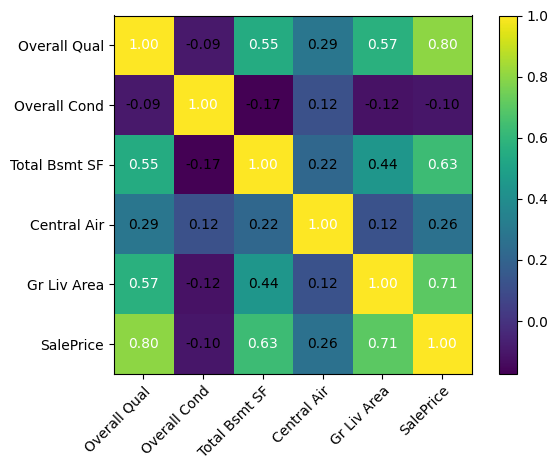

In [4]:
cm = np.corrcoef(ames_df.values.T)
hm = heatmap(cm, row_names=ames_df.columns, column_names=ames_df.columns)
plt.tight_layout()

## Construction of a Linear Regression model using Gradient Descent

In [5]:
class LinearRegressionGD:
    ''' This is functionally the same as AdalineGD from Chapter 2, however we remove the thresholding function '''
    
    def __init__(self,eta=0.01,n_iter=50,random_state=1):
        '''
            @param eta: learning rate
            @param n_iter: total epochs
            @param random_state = seed for random weight generation
        '''
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self,X,y):
        ''' 
            @param X: training data
            @param y: target values for training
        '''        
        rgen = np.random.RandomState(self.random_state)

        #Weights after fitting, X.shape[1] gives us the number of features
        #We init with small random numbers to start
        self.w_ = rgen.normal(loc=0.0,scale=0.01,size=X.shape[1]) 
        
        self.b_ = np.float_(0.) #Bias after fitting
        self.losses_ = [] #Number of miscalculations for each epoch

        for _ in range(self.n_iter):
            output = self.net_input(X)
            errors = (y-output)

            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()

            self.losses_.append(loss)

        return self
    
    def net_input(self,X):
        return np.dot(X,self.w_) + self.b_
    
    def predict(self,X):
        return self.net_input(X)
    
X = ames_df[['Gr Liv Area']].values
y = ames_df['SalePrice'].values

sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

lr = LinearRegressionGD(eta=.1)

lr.fit(X_std, y_std)

### Ensuring our model converged

Text(0.5, 0, 'Epoch')

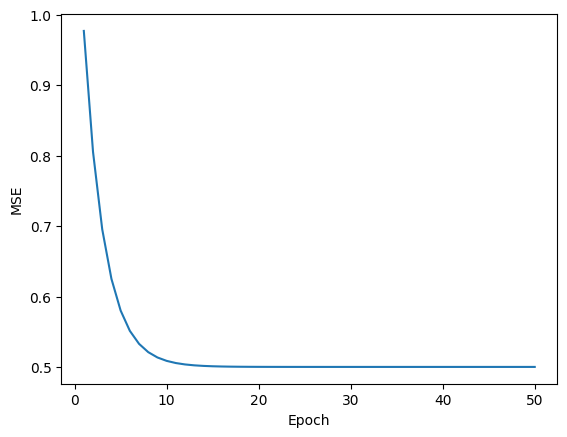

In [6]:
plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel("MSE")
plt.xlabel("Epoch")

### Visualizing the Linear Regression line of the model

Text(0, 0.5, 'Sale Price (Standardized)')

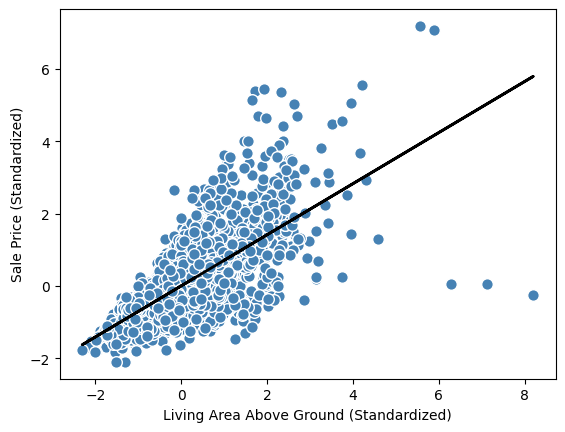

In [7]:
def lin_regplot(X, y, clf) -> None :
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, clf.predict(X), color='black', lw=2)
    
lin_regplot(X_std, y_std, lr)
plt.xlabel("Living Area Above Ground (Standardized)")
plt.ylabel("Sale Price (Standardized)")

### Predicting the price of a home with 2500sqft

In [8]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f'Sales Price: ${target_reverted.flatten()[0]:.2f}')

Sales Price: $292507.07


## Linear Regression with Scikit-Learn

Slope: 111.666
Intercept: 13342.979


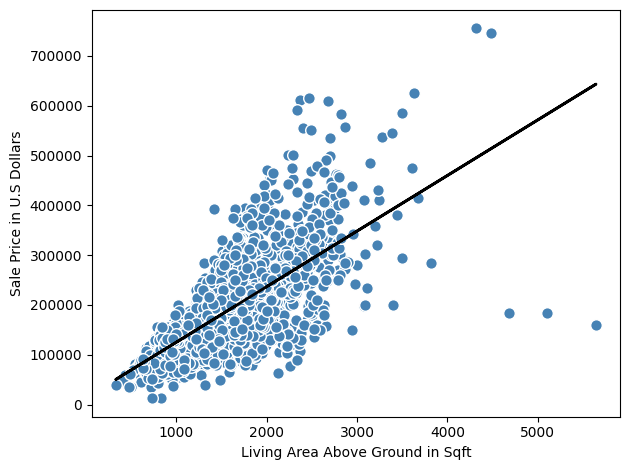

In [9]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)

y_pred = slr.predict(X)

print(f'Slope: {slr.coef_[0]:.3f}')
print(f'Intercept: {slr.intercept_:.3f}')

lin_regplot(X, y, slr)
plt.xlabel("Living Area Above Ground in Sqft")
plt.ylabel("Sale Price in U.S Dollars")
plt.tight_layout()

## Robust Linear Regression Model with RANSAC

In [10]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100,
    min_samples=.95,
    residual_threshold=None,
    random_state=123
)

ransac.fit(X, y)

print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 106.348
Intercept: 20190.093


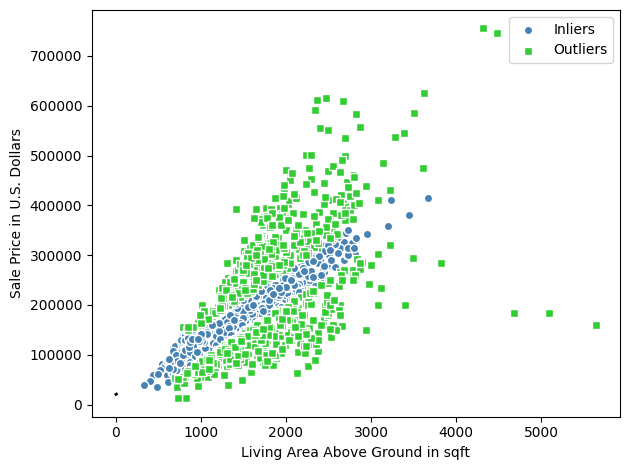

In [11]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(
    X[inlier_mask], y[inlier_mask], c='steelblue', edgecolor='white', marker='o', label='Inliers'
)

plt.scatter(
    X[outlier_mask], y[outlier_mask], c='limegreen', edgecolor='white', marker='s', label='Outliers'
)

plt.plot(
    line_X, line_y_ransac, color='black', lw=2
)

plt.xlabel("Living Area Above Ground in sqft")
plt.ylabel("Sale Price in U.S. Dollars")

plt.legend(loc='upper right')

plt.tight_layout()

## Evaluating Linear Regression Performance

In [12]:
from sklearn.model_selection import train_test_split

target = 'SalePrice'

features = ames_df.columns[ames_df.columns != target]

X = ames_df[features].values
y = ames_df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

slr = LinearRegression()

slr.fit(X_train, y_train)

y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

### Plotting Residuals

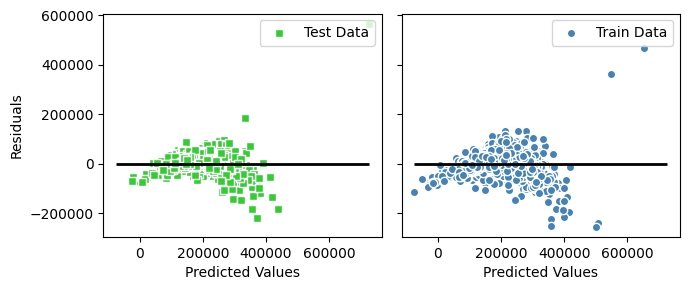

In [13]:
x_max = np.max(
    [np.max(y_train_pred), np.max(y_test_pred)]
)

x_min = np.min(
    [np.min(y_train_pred), np.min(y_test_pred)]
)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize = (7, 3), sharey=True
)

ax1.scatter(
    y_test_pred, y_test_pred - y_test,
    c='limegreen', marker='s', edgecolor='white',
    label='Test Data'
)

ax2.scatter(
    y_train_pred, y_train_pred - y_train,
    c='steelblue', marker='o', edgecolor='white',
    label='Train Data'
)

ax1.set_ylabel("Residuals")

for ax in (ax1, ax2):
    ax.set_xlabel("Predicted Values")
    ax.legend(loc='upper right')
    ax.hlines(y=0, xmin= x_min - 100, xmax= x_max + 100, color='black', lw=2)
    
plt.tight_layout()
plt.show()

### Scoring with Mean Squared Error (MSE)

In [14]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test  = mean_squared_error(y_test, y_test_pred)

print(f'MSE train: {mse_train:.2f}')
print(f'MSE test : {mse_test:.2f}')

MSE train: 1497216245.85
MSE test : 1516565821.00


### Scoring with Mean Absolute Error (MAE, or the square root of the MSE)

In [15]:
from sklearn.metrics import mean_absolute_error

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test  = mean_absolute_error(y_test, y_test_pred)

''' Model makes an error of approximately $25,000 on average '''
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test : {mae_test:.2f}')

MAE train: 25983.03
MAE test : 24921.29


### Scoring with Coefficient of Determination (R2 Score)

In [16]:
from sklearn.metrics import r2_score

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'R^2 train: {train_r2 : .2f}, test: {test_r2 : .2f}')

R^2 train:  0.77, test:  0.75


## Polynomial Regression

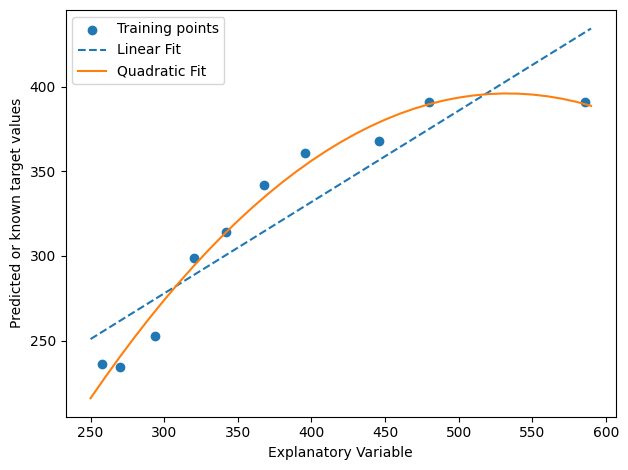

In [17]:
from sklearn.preprocessing import PolynomialFeatures

X = np.array(
    [258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0]
)[:, np.newaxis]

y = np.array(
    [236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8]
)

lr = LinearRegression()
pr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)

X_quad = quadratic.fit_transform(X)

lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, label='Linear Fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic Fit')
plt.xlabel("Explanatory Variable")
plt.ylabel("Predicted or known target values")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Calculating MSE and R2 Score

In [18]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

r2_lin = r2_score(y, y_lin_pred)
mse_lin = mean_squared_error(y, y_lin_pred)

r2_quad = r2_score(y, y_quad_pred)
mse_quad = mean_squared_error(y, y_quad_pred)

print(f'Training MSE Linear: {mse_lin : .3f}')
print(f'Training MSE Quadratic : {mse_quad : .3f}')

print(f'Training R2 Linear: {r2_lin : .3f}')
print(f'Training R2 Quadratic: {r2_quad : .3f}')

Training MSE Linear:  569.780
Training MSE Quadratic :  61.330
Training R2 Linear:  0.832
Training R2 Quadratic:  0.982


## Modeling Non-Linear Relationships in the Ames Housing Dataset

### Modeling relationship of Gr Liv Area and Sale Price, polynomial won't have much affect since they're generally linearlly correlated

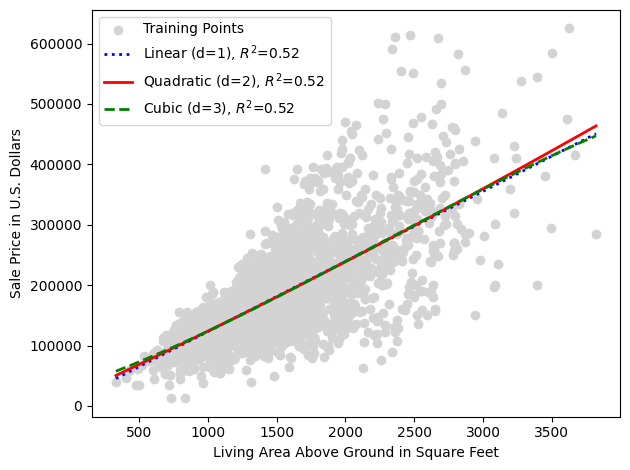

In [19]:
X = ames_df[['Gr Liv Area']].values
y = ames_df['SalePrice'].values

outlier_filter = (ames_df['Gr Liv Area'] < 4000) # remove outliers w/ more than 4k sqft living space

X = X[outlier_filter]
y = y[outlier_filter]

regr = LinearRegression()

# create quadratic and cubic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)

X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit to features
X_fit = np.arange(X.min() - 1, X.max() + 2, 1)[:,np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# Plot results

plt.scatter(X, y, label='Training Points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label=f'Linear (d=1), $R^2$={linear_r2:.2f}', color='blue', lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}', color='red', lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}', color='green', lw=2, linestyle='--')
plt.xlabel("Living Area Above Ground in Square Feet")
plt.ylabel("Sale Price in U.S. Dollars")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Now with Overall Qual, which isn't linearly correlated with Sale Price

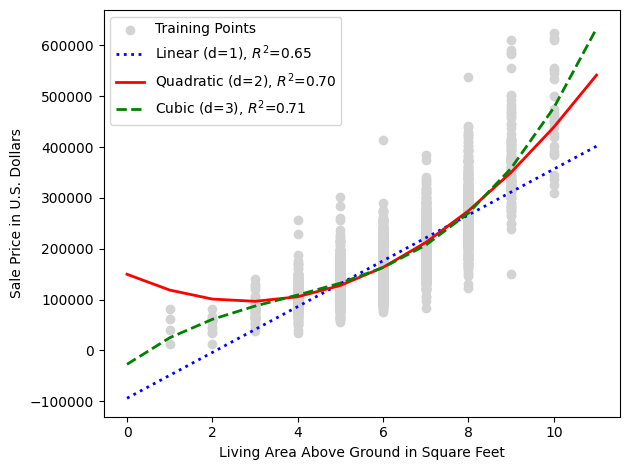

In [20]:
X = ames_df[['Overall Qual']].values
y = ames_df['SalePrice'].values

outlier_filter = (ames_df['Gr Liv Area'] < 4000) # remove outliers w/ more than 4k sqft living space

X = X[outlier_filter]
y = y[outlier_filter]

regr = LinearRegression()

# create quadratic and cubic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)

X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit to features
X_fit = np.arange(X.min() - 1, X.max() + 2, 1)[:,np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# Plot results

plt.scatter(X, y, label='Training Points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label=f'Linear (d=1), $R^2$={linear_r2:.2f}', color='blue', lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}', color='red', lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}', color='green', lw=2, linestyle='--')
plt.xlabel("Living Area Above Ground in Square Feet")
plt.ylabel("Sale Price in U.S. Dollars")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Decision Tree Regression

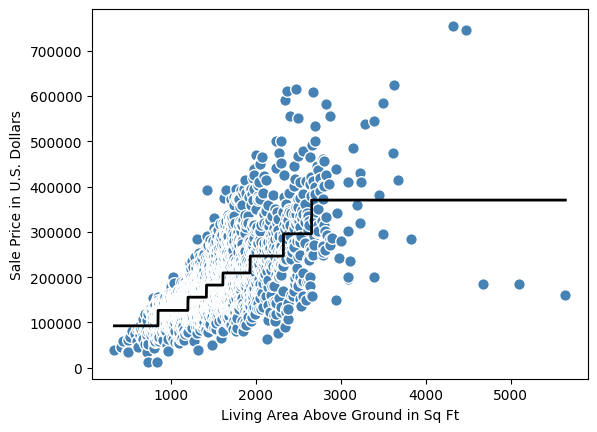

In [22]:
from sklearn.tree import DecisionTreeRegressor

X = ames_df[['Gr Liv Area']].values
y = ames_df['SalePrice'].values

tree = DecisionTreeRegressor(max_depth=3)

tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel("Living Area Above Ground in Sq Ft")
plt.ylabel("Sale Price in U.S. Dollars")
plt.show()

### Random Forest Regression

In [23]:
from sklearn.ensemble import RandomForestRegressor

target = 'SalePrice'
features = ames_df.columns[ames_df.columns != target]

X = ames_df[features].values
y = ames_df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

forest = RandomForestRegressor(n_estimators=1000, criterion='squared_error', random_state=1, n_jobs=1)

forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test  = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test, y_test_pred)

print(f'MAE Train: {mae_train : .2f}')
print(f'MAE Test : {mae_test : .2f}')
print(f'R2 Train: {r2_train : .2f}')
print(f'R2 Test : {r2_test : .2f}')

MAE Train:  8305.18
MAE Test :  20821.77
R2 Train:  0.98
R2 Test :  0.85


#### Plotting Residuals from Random Forest

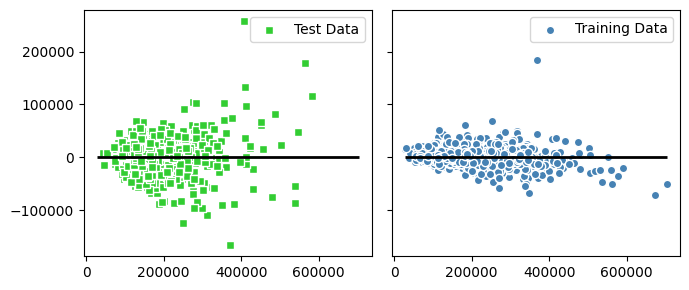

In [27]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(
    y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolor='white', label='Test Data'
)

ax2.scatter(
    y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolor='white', label='Training Data'
)

for ax in (ax1, ax2):
    ax.set_label("Predicted Values")
    ax.legend(loc='upper right')
    ax.hlines(y=0, xmin= x_min - 100, xmax= x_max + 100, color='black', lw=2)
    
plt.tight_layout()
plt.show()